Utilization of Mask-RCNN implementation by Matterport https://github.com/matterport/Mask_RCNN

Manage Imports

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage

Setup Mask-RCNN configuration variables

In [2]:
PROJ_ROOT_DIR = os.getcwd()
MASK_ROOT = os.path.join(PROJ_ROOT_DIR, "Mask_RCNN")
COCO_MODEL_DIR = os.path.join(MASK_ROOT, "mask_rcnn_coco.h5")
MODEL_CHECKPOINT_DIR = os.path.join(PROJ_ROOT_DIR, "models")
DEFAULT_LOGS_DIR = MODEL_CHECKPOINT_DIR
sys.path.append(PROJ_ROOT_DIR)
sys.path.append(MASK_ROOT)

Import the Mask-RCNN implementation module 

In [3]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


Setup Mask-RCNN dataset class

In [4]:
class BuoyConfig(Config):
    NAME = "bouy"

    IMAGE_RESIZE_MODE="square"
    IMAGE_MIN_DIM=128
    IMAGE_MAX_DIM=256
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 2
    STEPS_PER_EPOCH = 500

class BuoyDataset(utils.Dataset):

    def compose_im(self, x, sort_files, annotations_dir, im_dir):
        anno = json.load(open(annotations_dir+sort_files[x]))
        impath = os.path.join(im_dir, os.path.splitext(sort_files[x])[0])
        sz = anno["size"]
        pts = []
        for obj in anno["objects"]:
            if obj["classTitle"] == 'buoy':
                pts.append(obj["points"]["exterior"])
        self.add_image(
            "buoy",
            image_id=os.path.splitext(sort_files[x])[0],
            path=impath,
            width=sz["width"],
            height=sz["height"],
            polygons=pts
        )
        


    def load_buoys(self, stage="train"):
        self.add_class("buoy", 1, "buoy")
        annotations_dir = os.path.join(os.getcwd(), "buoy_data/Train/ann/")
        im_dir = os.path.join(os.getcwd(), "buoy_data/Train/img/")
        file_lst = os.listdir(path=annotations_dir)
        sort_files = sorted(file_lst)
        file_len = len(sort_files)
        train_count = int(file_len*.7)
        val_count = int(file_len*.3)
        if stage == 'train':
            for x in range(train_count):
                self.compose_im(x, sort_files, annotations_dir, im_dir)

        else:
            for x in range(val_count):
                self.compose_im(x+train_count, sort_files, annotations_dir, im_dir)


    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "buoy":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        all_x = []
        all_y = []
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            for pt in p:
                all_x.append(pt[0])
                all_y.append(pt[1])
            rr, cc = skimage.draw.polygon(all_y, all_x)
            mask[rr-1, cc-1, i] = 1
            all_x = []
            all_y = []

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "buoy":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

Create Model and Fetch COCO weights

In [5]:
utils.download_trained_weights(COCO_MODEL_DIR)

... done downloading pretrained model!


In [5]:
model = modellib.MaskRCNN(mode='training', config=BuoyConfig(), model_dir=MODEL_CHECKPOINT_DIR)
model.load_weights(COCO_MODEL_DIR, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
                                
# in case training gets interuppted, have ability to start from last save point
# model.load_weights(model.find_last(), by_name=True)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








Train Model

In [6]:
train_data = BuoyDataset()
train_data.load_buoys("train")
train_data.prepare()
val_data = BuoyDataset()
val_data.load_buoys("val")
val_data.prepare()

In [7]:
model.train(train_data, val_data, learning_rate=BuoyConfig.LEARNING_RATE, epochs=5, layers="all")

830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
499/500 [============================>.] - ETA: 0s - loss: 0.3580 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1292c:\CV-Proj\venv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\CV-Proj\venv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolat

Manually save model and end of training (model should already be saved by callbacks, but never hurts to be safe)

In [8]:
model_path = os.path.join(MODEL_CHECKPOINT_DIR, "mask_rcnn_buoys.h5")
model.keras_model.save_weights(model_path)

Inference Stage: Test baby test!

In [9]:
class TestBuoy(BuoyConfig):
    pass

model_test = modellib.MaskRCNN(mode="inference", config=TestBuoy(), model_dir=MODEL_CHECKPOINT_DIR)
model_path = model_test.find_last()
print(model_path)
model_test.load_weights(model_path, by_name=True)





Instructions for updating:
Use `tf.cast` instead.
c:\CV-Proj\models\bouy20210428T1854\mask_rcnn_bouy_0005.h5
Re-starting from epoch 5


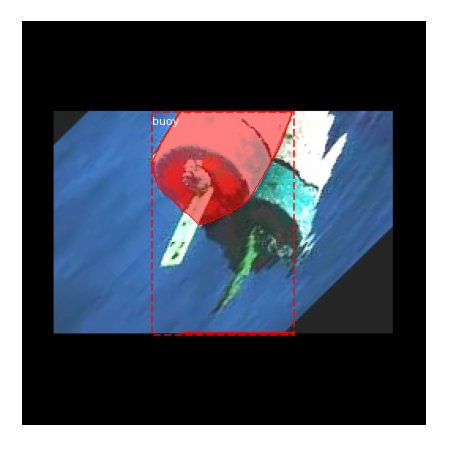

In [10]:
image_id = random.choice(val_data.image_ids)
orig, meta, gt_class, gt_bbox, gt_mask = modellib.load_image_gt(val_data, TestBuoy(), image_id, use_mini_mask=False)

visualize.display_instances(orig, gt_bbox, gt_mask, gt_class, 
                            train_data.class_names, figsize=(8, 8))

Utility function borrow Matterport/Mask_RCNN/samples/train_shapes.ipynb

In [11]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


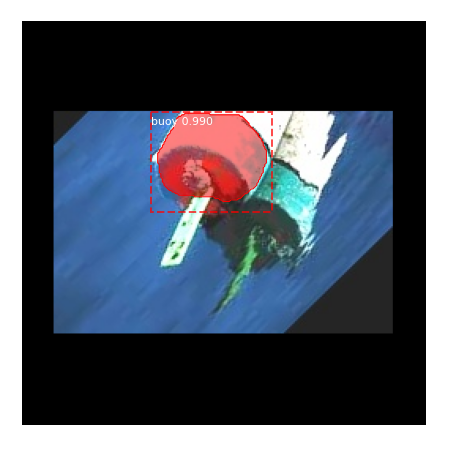

In [12]:
results = model_test.detect([orig], verbose=1)
r = results[0]
visualize.display_instances(orig, r['rois'], r['masks'], r['class_ids'], 
                            val_data.class_names, r['scores'], ax=get_ax())

In [1]:
image_ids = np.random.choice(val_data.image_ids, 3)
for im_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(val_data, TestBuoy(),
                               im_id, use_mini_mask=False)
    results = model_test.detect([image], verbose=0)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            val_data.class_names, r['scores'], ax=get_ax())

    

NameError: name 'np' is not defined

Compute mean Average Precision - utilizing script from Github repo Matterport/Mask_RCNN/samples/train_shapes.ipynb

In [23]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(val_data.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(val_data, TestBuoy(),
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, TestBuoy()), 0)
    # Run object detection
    results = model_test.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9642410719394684
